In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib
import itertools

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [4]:
### load already created
hist_3d = np.load(os.path.join(cluster_dir, '20221210_3d_hists.npy'))
hist_3d.shape

(251, 2, 400, 25, 25)

In [5]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [6]:
### load behavior ###
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/20221202_master_X_noYclip.npy"
X_beh = np.load(file)
X_beh.shape

(49, 9, 2000, 3384)

In [7]:
# the main thing to deal with now is the z-depth
# for a given supercluster, i need to know the original median z-depth for each fly
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


In [8]:
superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

(256, 128, 49)

In [9]:
original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:24<00:00,  2.78s/it]


In [133]:
cluster_ = 133#77#204

### behavior bins
start_x=-2; end_x=6;
start_y=-4; end_y=4
num_bins_x=25; num_bins_y=25
#num_bins_x=10; num_bins_y=10


### Define bins
bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

###
Xs_new = []
for fly in range(9):
    Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
Xs_new = np.asarray(Xs_new)
beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

X_ind = []; Y_ind = []
for j,shift in tqdm.tqdm(enumerate(np.arange(-200,200,1))): #change back to "1" instead of "10"
    Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
    Y_var /= np.std(Y_var)

    X_var = beh_cluster[250+shift,:]
    X_var /= np.std(X_var)

    # Assign fictrac values to bin numbers
    idx_x, idx_y = np.digitize(X_var,bins_x), np.digitize(Y_var,bins_y)
    X_ind.append(idx_x)
    Y_ind.append(idx_y)
    
X_ind = np.asarray(X_ind)
Y_ind = np.asarray(Y_ind)

# need to flip and shift y axis to get it to align correctly
# not exactly sure where this discepancy came from but I'm pretty sure this fixes it
Y_ind = np.clip((25-Y_ind)-1,0,None)
# small adjustment
X_ind = np.clip(X_ind,None,24)

400it [00:00, 777.60it/s]


In [58]:
### how to turn this into cross-validated model?
#each spatiotemporal bin is a variable
#input is binary vector
Y_ind.shape


(8, 30456)

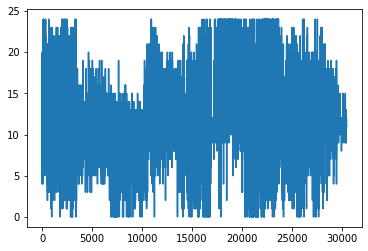

In [32]:
plt.plot(Y_ind[200,:])

In [120]:
(25*25)

625

In [134]:
# turn into one-hot
X = np.zeros((25,25,30456))
for i in range(30456):
    X[Y_ind[200,i],X_ind[200,i],i] = 1
X = np.reshape(X,(25*25,30456))
X = X.T
X.shape

(30456, 625)

In [77]:
# turn into one-hot, with temporal
tp = 40
s = 11
X = np.zeros((tp,s,s,30456))
for t in range(tp):
    for i in range(30456):
        X[t,Y_ind[t,i],X_ind[t,i],i] = 1
X = np.reshape(X,(tp*s*s,30456))
X = X.T
X.shape

(30456, 4840)

In [157]:
X_ind.shape

(400, 30456)

In [116]:
# # turn each tp into a unique index (616 values)
# beh_index = (Y_ind[200,:]*24)+X_ind[200,:]

# # turn into one-hot
# X = np.zeros((25*25,30456))
# for i in range(np.max(beh_index)):
#     X[i,beh_index==i] = 1
# X = X.T
# X.shape

(30456, 592)

In [101]:
np.max(X_ind[200,:]),np.max(Y_ind[200,:]), 

(24, 24)

In [104]:
24*25

600

In [107]:
beh_index = (Y_ind[200,:]*25)+X_ind[200,:]
np.max(beh_index)

641

In [ ]:
1

In [59]:
X_ind_reconstitute = beh_index%25
Y_ind_reconstitute = np.floor(beh_index/25).astype('int')

In [97]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [135]:
Y = supercluster_signals[cluster_,]

In [136]:
model = RidgeCV().fit(X, Y)
model.score(X, Y)

0.01151073226417676

In [137]:
prediction = model.predict(X)

(-0.2, 0.2)

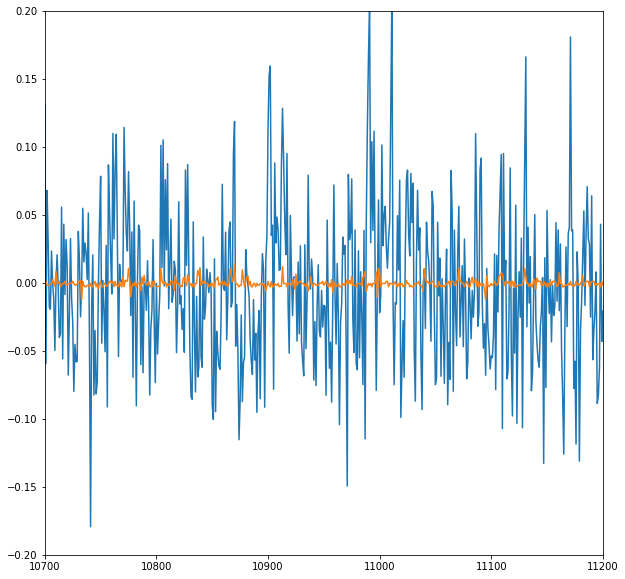

In [138]:
plt.figure(figsize=(10,10))
plt.plot(Y)
plt.plot(prediction)
plt.xlim(10700,11200)
plt.ylim(-.2,.2)

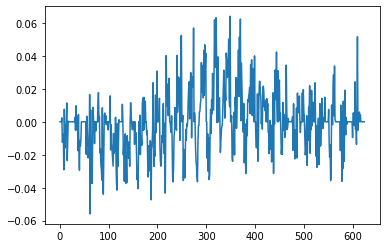

In [130]:
plt.plot(model.coef_)

In [89]:
X_ind_reconstitute = beh_index%25
Y_ind_reconstitute = np.floor(beh_index/25).astype('int')

In [ ]:
for i in range

In [96]:
beh_index%25

array([ 5,  8, 11, ...,  7,  6,  7])

In [139]:
out = np.reshape(model.coef_,(25,25))

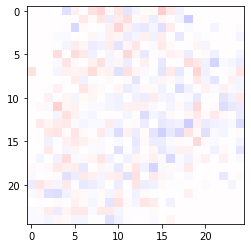

In [140]:
plt.imshow(out,cmap='seismic',vmin=-.2,vmax=.2)

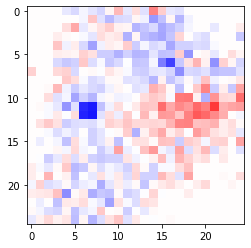

In [156]:
plt.imshow(out,cmap='seismic',vmin=-.1,vmax=.1)

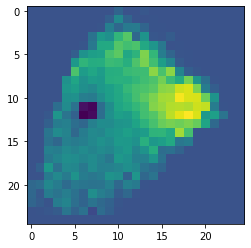

In [98]:
plt.imshow(hist_3d[26,0,200,:,:])

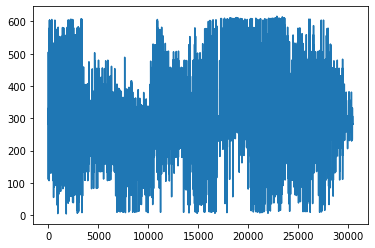

In [40]:
plt.plot(beh_index)

In [27]:
supercluster_signals[cluster_,].shape

(30456,)

In [ ]:
### first try instantaneous model
# need to turn a fwd (0 to 25), and a rotational (0 to 25) to a single number


Y_ind



In [409]:
# ok this is looking pretty sick
# however, I'd like to know why the prediction is 10x higher

In [11]:
beh_filter = hist_3d[cluster_,0,:,:,:]

In [12]:
np.min(beh_filter), np.max(beh_filter)

(-0.044432368413568235, 0.08626288223151873)

In [13]:
prediction = []
for tp in range(30456):
    prediction.append(np.sum(beh_filter[::-1][list(range(400)),Y_ind[:,tp],X_ind[:,tp]]))
r, p = scipy.stats.pearsonr(prediction, supercluster_signals[cluster_,])
r

0.5453391197268873

In [16]:
beh_cluster.shape

(2000, 30456)

In [17]:
supercluster_signals[cluster_,].shape

(30456,)

In [20]:
temp = beh_cluster[250,:]
r, p = scipy.stats.pearsonr(temp, supercluster_signals[cluster_,])
r

0.2901059652981102

(2600, 3000)

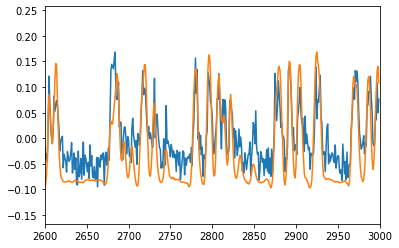

In [25]:
plt.plot(supercluster_signals[cluster_,7000:10000])
plt.plot([i/25+.02 for i in prediction[7000:10000]])
plt.xlim(2600,3000)

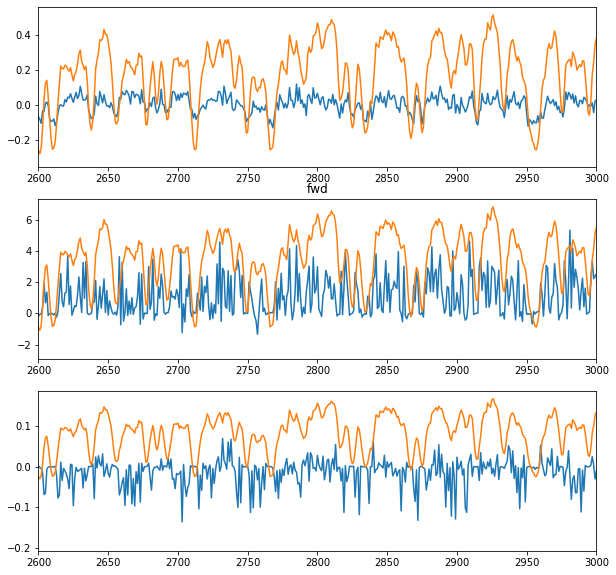

In [417]:
start = 20000
stop = 25000

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(supercluster_signals[cluster_,start:stop])
plt.plot([i/10 for i in prediction[start:stop]])
plt.xlim(2600,3000)

plt.subplot(312)
plt.plot(beh_cluster[250,start:stop])
plt.xlim(2600,3000)
plt.plot([i+1.7 for i in prediction[start:stop]])
plt.title('fwd')

plt.subplot(313)
temp = beh_cluster[750,:]+beh_cluster[1250,:]*-1
plt.plot(temp[start:stop])
plt.xlim(2600,3000)
plt.plot([i/40+.04 for i in prediction[start:stop]])

# loop version

In [405]:
rs = []
for cluster_ in tqdm.tqdm(range(251)):
    ### behavior bins
    start_x=-2; end_x=6;
    start_y=-4; end_y=4
    num_bins_x=25; num_bins_y=25

    ### Define bins
    bins_x, bins_y = np.linspace(start_x,end_x,num_bins_x), np.linspace(start_y,end_y,num_bins_y)

    ###
    Xs_new = []
    for fly in range(9):
        Xs_new.append(X_beh[original_z_depth[fly,cluster],fly,:,:])
    Xs_new = np.asarray(Xs_new)
    beh_cluster = np.reshape(np.moveaxis(Xs_new,0,1),(-1,30456))

    X_ind = []; Y_ind = []
    for j,shift in enumerate(np.arange(-200,200,1)):
        Y_var = beh_cluster[750+shift,:]+beh_cluster[1250+shift,:]*-1
        Y_var /= np.std(Y_var)

        X_var = beh_cluster[250+shift,:]
        X_var /= np.std(X_var)

        # Assign fictrac values to bin numbers
        idx_x, idx_y = np.digitize(X_var,bins_x), np.digitize(Y_var,bins_y)
        X_ind.append(idx_x)
        Y_ind.append(idx_y)

    X_ind = np.asarray(X_ind)
    Y_ind = np.asarray(Y_ind)

    # need to flip and shift y axis to get it to align correctly
    # not exactly sure where this discepancy came from but I'm pretty sure this fixes it
    Y_ind = np.clip((25-Y_ind)-1,0,None)
    # small adjustment
    X_ind = np.clip(X_ind,None,24)

    beh_filter = hist_3d[cluster_,0,:,:,:]

    prediction = []
    for tp in range(30456):
        prediction.append(np.sum(beh_filter[::-1][list(range(400)),Y_ind[:,tp],X_ind[:,tp]]))
    r, p = scipy.stats.pearsonr(prediction, supercluster_signals[cluster_,])
    rs.append(r)

100%|██████████| 251/251 [07:04<00:00,  1.69s/it]


(array([ 2.,  6., 23., 39., 28., 46., 42., 43., 14.,  8.]),
 array([0.04303128, 0.0952161 , 0.14740093, 0.19958575, 0.25177058,
        0.3039554 , 0.35614023, 0.40832505, 0.46050988, 0.5126947 ,
        0.56487953]),
 <a list of 10 Patch objects>)

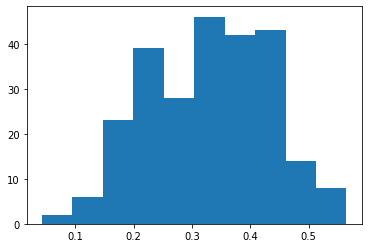

In [406]:
plt.hist(rs)

In [418]:
np.argsort(rs)

array([235,  75, 238,  23,   0, 236, 244,  83, 133, 208, 210,  49, 170,
       104,  13,  48,  54,  63,  99, 247, 207, 250, 131, 158, 239, 234,
        98, 205,  42, 201,  29, 141, 144, 166, 191, 222, 227, 105,  91,
       214, 218,  40, 172, 110, 126,  50, 209, 225, 228, 185, 206, 102,
        95, 215, 195,  74, 101,  36, 108, 248,  73, 146, 179, 181, 243,
        94, 153, 139, 242,  69, 241, 224, 160,  76, 226,  68, 137,  22,
         3, 138, 155,  67, 204,  19, 188,  77,  60, 111,  66, 192,  97,
       219, 202, 200, 196, 156,  27, 174,   4, 151,  12, 180,  51, 187,
        96,   6, 167, 148, 231,  82, 135,  81, 240, 136, 130, 117,  38,
        80, 217,  72,  21, 157, 128,  70,  28,   1, 119, 175, 122, 143,
       162, 116, 145,  10, 127, 199, 198, 112, 123,  18,  88, 176, 164,
        61, 100,  43, 233, 220, 189,  59,  11,  84,  65,  32,  85, 147,
       169,  71, 159, 186,  89,  64, 213, 132, 152,  46,  92,  78,   8,
       163, 223,   9, 194, 120,  20,  24,  56, 183,  86, 109, 19

# can we use prediction peaks to identify bouts?

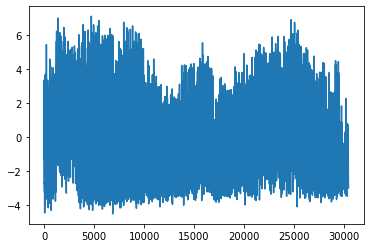

In [396]:
plt.plot(prediction)

In [402]:
peaks = scipy.signal.find_peaks(prediction,height=6)[0]
len(peaks)

34

(5000, 5200)

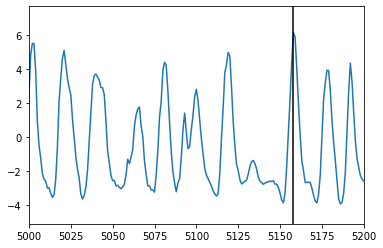

In [403]:
plt.plot(prediction)
for peak in peaks:
    plt.axvline(peak,color='k')
plt.xlim(5000,5200)

(2600, 3000)

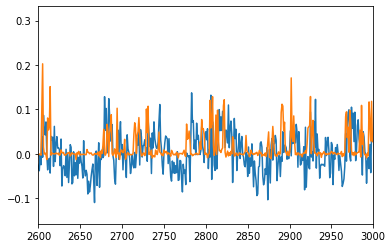

In [346]:
plt.plot(supercluster_signals[cluster_,7000:10000])
plt.plot(beh_cluster[250,7000:10000]/20)
plt.xlim(2600,3000)


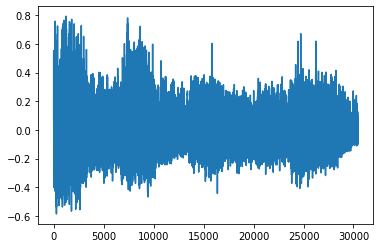

In [287]:
plt.plot(supercluster_signals[cluster_,:])

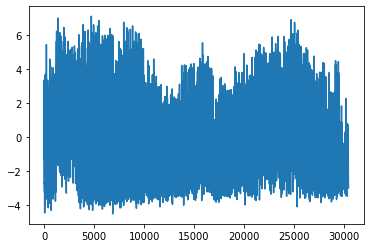

In [286]:
plt.plot(prediction)

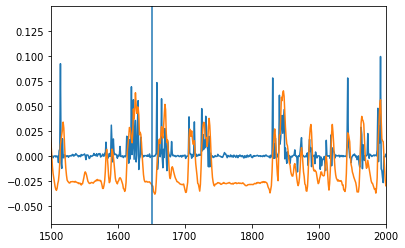

In [276]:
temp = beh_cluster[750,:]+beh_cluster[1250,:]*-1
plt.plot(temp[7000:10000])
plt.plot([i/100 for i in prediction[7000:10000]])

plt.xlim(1500,2000)
plt.axvline(1650)

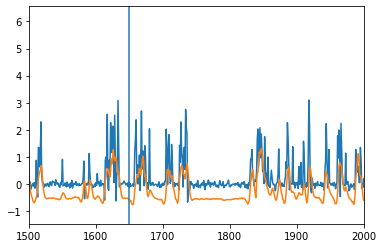

In [280]:
plt.plot(beh_cluster[250,7000:10000])
plt.plot([i/5 for i in prediction[7000:10000]])

plt.xlim(1500,2000)
plt.axvline(1650)

(500, 600)

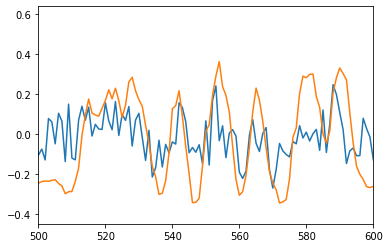

In [260]:
plt.plot(supercluster_signals[cluster_,20000:23000])
plt.plot([i/10 for i in prediction[20000:23000]])
plt.xlim(500,600)

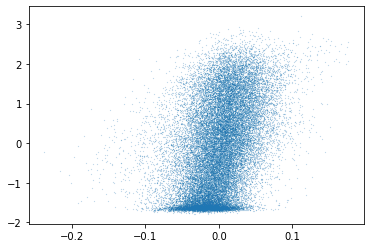

In [305]:
plt.scatter(supercluster_signals[cluster_,:],prediction,s=.01)

0.4064722671555793

In [ ]:
r, p = scipy.stats.pearsonr(prediction, supercluster_signals[cluster_,])
r

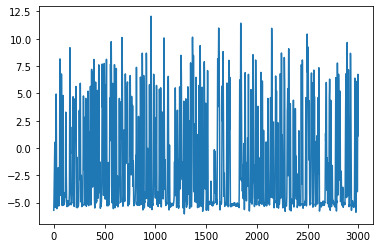

In [159]:
plt.plot(prediction[7000:10000])

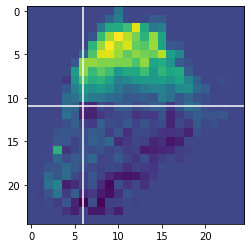

In [179]:
tp=300
plt.imshow(beh_filter[200,:,:])
plt.axhline(11,color='w')
plt.axvline(6,color='w')

#plt.scatter(X_ind[0,:],Y_ind[0,:])

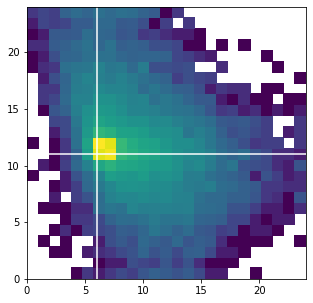

In [180]:
plt.figure(figsize=(5,5))
plt.hist2d(X_ind[0,:], Y_ind[0,:],bins=25,norm=LogNorm());
plt.axhline(11,color='w')
plt.axvline(6,color='w')


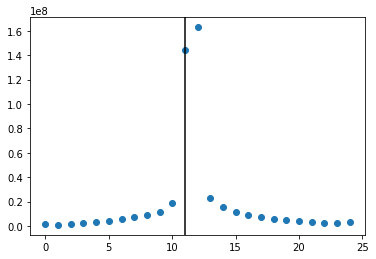

In [144]:
b = []
for i in np.unique(Y_ind):
    a = np.sum(np.where(new==i))
    b.append(a)
    
plt.plot(np.unique(Y_ind),b,'o')
plt.axvline(11,color='k')

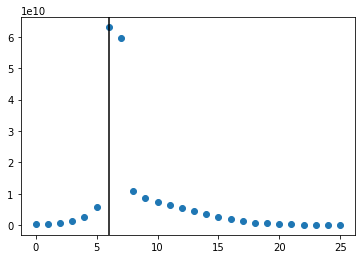

In [147]:
b = []
for i in np.unique(X_ind):
    a = np.sum(np.where(X_ind==i))
    b.append(a)
    
plt.plot(np.unique(X_ind),b,'o')
plt.axvline(6,color='k')

In [101]:
np.clip(25-Y_ind[0,:100],1,None)

array([12, 12, 12, 12, 12, 12, 12, 12, 12,  9,  9,  9, 12, 14, 12, 13, 13,
       13, 12, 13, 12, 13, 13, 12, 12, 13, 12, 13, 12, 12, 12, 13, 12, 12,
       13, 12, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 12, 13, 13, 12,
       12, 10, 14, 14, 13, 13, 12, 13, 12, 12, 12,  8,  6, 11,  8, 11, 12,
       13, 13, 12, 12, 12, 12, 13, 13, 12, 12, 13, 12, 13, 13, 13, 13, 13,
       13, 13, 11, 10, 13, 14,  9, 13, 13, 15, 13, 12, 13, 12, 12])

In [89]:
len(np.unique(np.clip(25-Y_ind[0,:],1,None)))

25

In [77]:
from matplotlib.colors import LogNorm

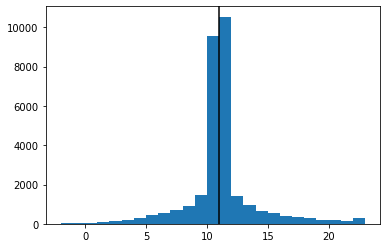

In [113]:
plt.hist((25-Y_ind[0,:])-2,bins=25)
plt.axvline(11,color='k')

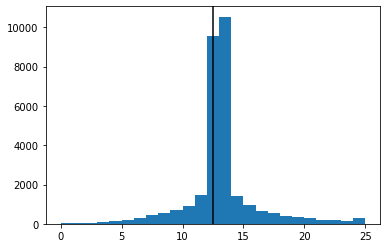

In [107]:
plt.hist(25-Y_ind[0,:],bins=25)
plt.axvline(12.5,color='k')

(array([   14.,    37.,    90.,   190.,   407.,   893., 10150.,  9579.,
         1697.,  1408.,  1266.,  1030.,   918.,   700.,   575.,   461.,
          331.,   201.,   157.,   125.,    75.,    56.,    32.,    18.,
           46.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 <a list of 25 Patch objects>)

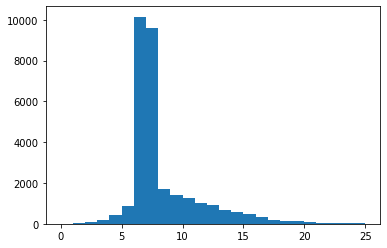

In [73]:
plt.hist(X_ind[0,:],bins=25)

In [14]:
beh_cluster.shape

(2000, 30456)

In [ ]:
# first (49, 9, 2000, 3384)
# then (2000, 30456)

# really I want (2, 400, 30456) of behavior indicies
# I will also have the 3d filter of (400, 25, 25)
# then I loop over tps
bi[0,:] # 400 
3d_filter[list(np.range(400)),bi[0,:],bi[1,:]] # this should do it

In [ ]:
# once I have the Y and X beh variables at 30456

In [ ]:
# lets take some single tp as an example


In [12]:
Y_var.shape

(30456,)

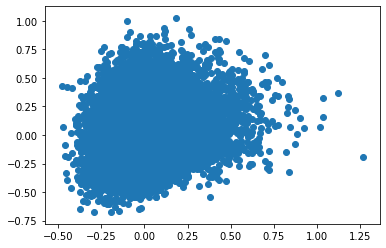

In [420]:
plt.scatter(supercluster_signals[21,:],supercluster_signals[185,:])

(5200, 5600)

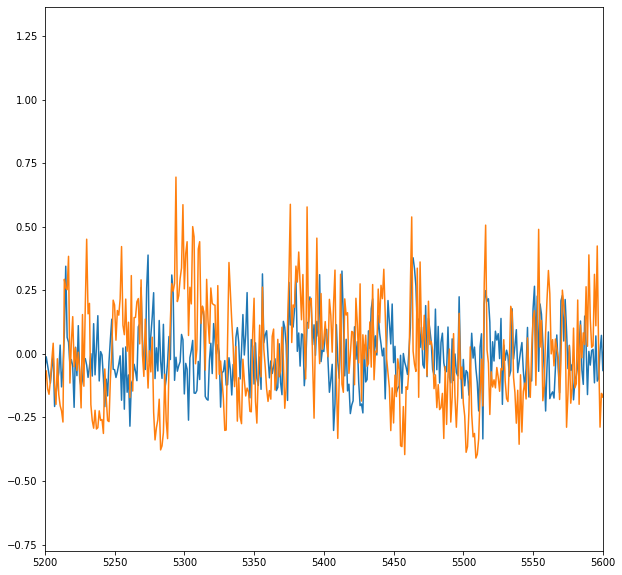

In [425]:
plt.figure(figsize=(10,10))
plt.plot(supercluster_signals[21,:])
plt.plot(supercluster_signals[185,:])
plt.xlim(5200,5600)

In [426]:
a = supercluster_signals[21,:]
b = supercluster_signals[185,:]

r, p = scipy.stats.pearsonr(a, b)
r

0.16510462094079256